In [1]:
import netket as nk
from netket.operator.spin import sigmax,sigmaz
import jax
import time

L = 20
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=False)
hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
t = time.time()
evals = nk.exact.lanczos_ed(ha, compute_eigenvectors=True)
gs = evals[1]
print("The ground-state energy is ", evals[0])

The ground-state energy is  [-34.72989334]


In [5]:
from netket.operator.spin import sigmax, sigmay, sigmaz
from scipy.sparse.linalg import eigsh
J1 = -1.0
L = 10
H = sum([J1*(sigmax(hi,i)*sigmax(hi,i+1)+sigmay(hi,i)*sigmay(hi,i+1)+sigmaz(hi,i)*sigmaz(hi,i+1)) for i in range(L-1)])
sp_h = H.to_sparse()
eig_vals, eig_vecs = eigsh(sp_h, k=12, which="SA")
print("eigenvalues with scipy sparse:", eig_vals)

eigenvalues with scipy sparse: [-9.         -9.         -8.80422607 -9.         -8.80422607 -9.
 -8.80422607 -9.         -9.         -9.         -9.         -9.        ]


In [5]:
print(eig_vals.dtype)

float64


In [3]:
(gs**2).ravel().sum()

1.000000000000001

In [2]:
import numpy as np
probs_exact = (gs**2).ravel()
spin_correlation_exact = []

for i in range (L-1):
    p_middle = np.sum(np.split(probs_exact, 2**i), axis=0)
    p_1, p_2 = np.split(p_middle, 2)
    p_1 = np.sum(np.split(p_1, 2**(L-i-2)), axis=0)
    p_2 = np.sum(np.split(p_2, 2**(L-i-2)), axis=0)
    p = np.concatenate((p_1, p_2),axis=None)
    spin_correlation_exact.append(p[0]+p[-1]-p[1]-p[2]-(p[0]+p[1]-p[2]-p[3])*(p[0]-p[1]+p[2]-p[3]))
p_itself = np.sum(np.split(probs_exact, 2**(L-1)), axis = 0)
spin_correlation_exact.append(np.sum(p_itself**2)-(p_itself[0]-p_itself[1])**2)

In [47]:
np.sum(np.split(probs_exact, 2), axis=0).shape

(2097152,)

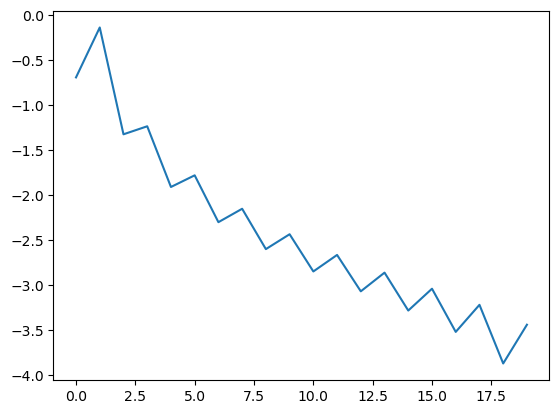

In [3]:
import matplotlib.pyplot as plt

plt.plot(np.flip(np.log(np.abs(spin_correlation_exact))))

In [ ]:
# Here we consider four cuts xx|xxxxxx|xxxx|xxxx|xx, the first and the last one determine the size of ABC, the middle two
# determine how we decompose the system ABC.
N = 2**20
system_size = 20
# initialization
p_abc = probs_exact+1e-24

cmi = []
for i in range (system_size-1):
    cmi.append(np.array([]))
for x in range (system_size):
    print(x)
    for i in range (x+1,system_size):
        print(i)
        for j in range (i, system_size):     # i, j is the cut position
            for k in range (j+1 ,system_size+1):

                p_abc_new = np.sum(np.split(np.sum(np.split(p_abc, 2**k), axis = 1), 2**x) , axis = 0)

                p_ab = np.sum(np.split(p_abc_new, 2**(j-x)), axis = 1)

                p_bc = np.sum(np.split(np.sum(np.split(np.sum(np.split(p_abc, 2**k), axis = 1), 2**x) , axis = 0), 2**(i-x)), axis = 0)
                if (j == i):
                    cmi[j-i] = np.append(cmi[j-i],(np.sum(-p_ab*np.log(p_ab)) -np.sum(p_bc*np.log(p_bc)) + np.sum(p_abc_new*np.log(p_abc_new))))
                else :
                    p_b = np.sum(np.split(p_ab, 2**(i-x)), axis = 0)
                    cmi[j-i] = np.append(cmi[j-i],(np.sum(-p_ab*np.log(p_ab)) -np.sum(p_bc*np.log(p_bc)) + np.sum(p_abc_new*np.log(p_abc_new)) + np.sum(p_b*np.log(p_b))))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1
2
3
4
5


In [ ]:
print(cmi)

In [ ]:
# Here we consider four cuts xx|xxxxxx|xxxx|xxxx|xx, the first and the last one determine the size of ABC, the middle two
# determine how we decompose the system ABC.
N = 2**22
system_size = 22
# initialization

p_abc_new = np.ones((system_size, system_size+1, N))
p_ab = np.ones((system_size, system_size, N))
p_bc = np.ones((system_size, system_size, N))
p_b = np.ones((system_size, system_size, N))

cmi = []
for i in range (system_size-1):
    cmi.append(np.array([]))
for x in range (system_size):
    for i in range (x+1,system_size):
        for j in range (i, system_size):     # i, j is the cut position
            for k in range (j+1 ,system_size+1):

                p_abc_new = np.ones((system_size, system_size+1, N))
                p_ab = np.ones((system_size, system_size, N))
                p_bc = np.ones((system_size, system_size, N))
                p_b = np.ones((system_size, system_size, N))

                p_abc_new[x, k, :2**(k-x)] = np.sum(np.split(np.sum(np.split(p_abc, 2**k), axis = 1), 2**x) , axis = 0)

                p_ab[i-1, j-1, :2**(j-x)] = np.sum(np.split(p_abc_new[x, k, :2**(k-x)], 2**(j-x)), axis = 1)

                p_bc[i - 1, j - 1, : int(2**(k-i))] = np.sum(np.split(p_abc_new[x, k, :2**(k-x)], 2**(i-x)), axis = 0)
                if (j == i):
                    pass
                else :
                    p_b[i - 1, j - 1, : 2**(j-i)] = np.sum(np.split(p_ab[i - 1, j - 1, :2**(j-x)], 2**(i-x)), axis = 0)
                cmi[j-i] = np.append(cmi[j-i],(np.sum(-p_ab[i-1, j-1]*np.log(p_ab[i-1, j-1]) -p_bc[i-1, j-1]*np.log(p_bc[i-1, j-1]) \
                                   + p_abc_new[x, k]*np.log(p_abc_new[x,k]) + p_b[i-1, j-1]*np.log(p_b[i-1, j-1]))))


In [6]:
import numpy as np
import matplotlib.pyplot as plt
cmi1 = np.load("cmi_L=20_J2=0.0.npy")
cmi2 = np.load("cmi_L=20_J2=0.2.npy")
cmi3 = np.load("cmi_L=20_J2=0.4.npy")
cmi4 = np.load("cmi_L=20_J2=0.45.npy")
cmi5 = np.load("cmi_L=20_J2=0.5.npy")
cmi6 = np.load("cmi_L=20_J2=0.55.npy")
cmi7 = np.load("cmi_L=20_J2=0.6.npy")
cmi8 = np.load("cmi_L=20_J2=0.8.npy")
cmi9 = np.load("cmi_L=20_J2=1.0.npy")


In [7]:
var_cmi1 = np.load("var_cmi_L=20_J2=0.0.npy")
var_cmi2 = np.load("var_cmi_L=20_J2=0.2.npy")
var_cmi3 = np.load("var_cmi_L=20_J2=0.4.npy")
var_cmi4 = np.load("var_cmi_L=20_J2=0.45.npy")
var_cmi5 = np.load("var_cmi_L=20_J2=0.5.npy")
var_cmi6 = np.load("var_cmi_L=20_J2=0.55.npy")
var_cmi7 = np.load("var_cmi_L=20_J2=0.6.npy")
var_cmi8 = np.load("var_cmi_L=20_J2=0.8.npy")
var_cmi9 = np.load("var_cmi_L=20_J2=1.0.npy")

In [8]:
correlation1 = np.load("spin_correlation_exact_L=20_J2=0.0.npy")
correlation2 = np.load("spin_correlation_exact_L=20_J2=0.2.npy")
correlation3 = np.load("spin_correlation_exact_L=20_J2=0.4.npy")
correlation4 = np.load("spin_correlation_exact_L=20_J2=0.45.npy")
correlation5 = np.load("spin_correlation_exact_L=20_J2=0.5.npy")
correlation6 = np.load("spin_correlation_exact_L=20_J2=0.55.npy")
correlation7 = np.load("spin_correlation_exact_L=20_J2=0.6.npy")
correlation8 = np.load("spin_correlation_exact_L=20_J2=0.8.npy")
correlation9 = np.load("spin_correlation_exact_L=20_J2=1.0.npy")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7084\2805907256.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.flip(np.log(np.abs(correlation5))), label = "J2=0.5")


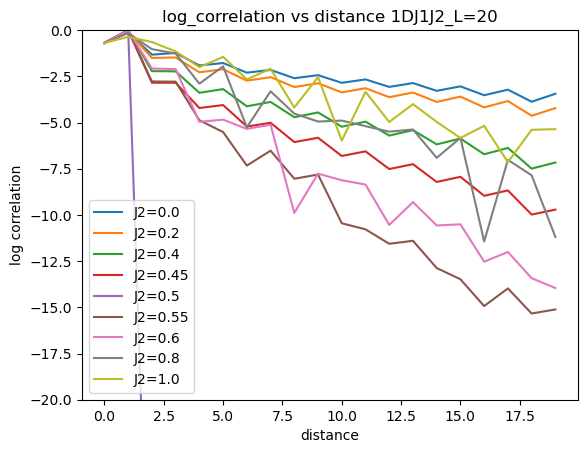

In [19]:
plt.plot(np.flip(np.log(np.abs(correlation1))), label = "J2=0.0")
plt.plot(np.flip(np.log(np.abs(correlation2))), label = "J2=0.2")
plt.plot(np.flip(np.log(np.abs(correlation3))), label = "J2=0.4")
plt.plot(np.flip(np.log(np.abs(correlation4))), label = "J2=0.45")
plt.plot(np.flip(np.log(np.abs(correlation5))), label = "J2=0.5")
plt.plot(np.flip(np.log(np.abs(correlation6))), label = "J2=0.55")
plt.plot(np.flip(np.log(np.abs(correlation7))), label = "J2=0.6")
plt.plot(np.flip(np.log(np.abs(correlation8))), label = "J2=0.8")
plt.plot(np.flip(np.log(np.abs(correlation9))), label = "J2=1.0")
plt.xlabel("distance")
plt.ylabel("log correlation")
plt.ylim(-20, 0)
plt.title("log_correlation vs distance 1DJ1J2_L=20")
plt.legend()
plt.show()


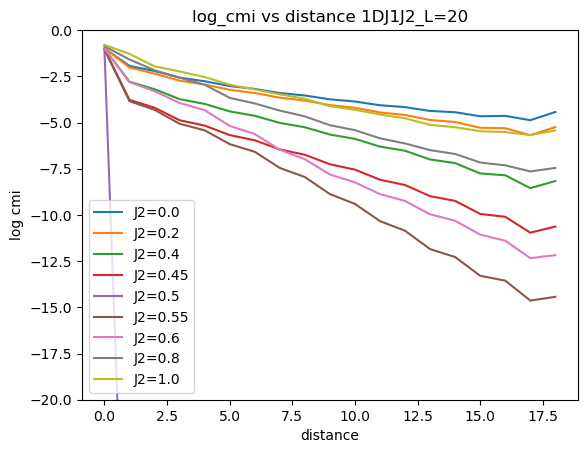

In [18]:
plt.plot(np.log(np.abs(cmi1)), label = "J2=0.0")
plt.plot(np.log(np.abs(cmi2)), label = "J2=0.2")
plt.plot(np.log(np.abs(cmi3)), label = "J2=0.4")
plt.plot(np.log(np.abs(cmi4)), label = "J2=0.45")
plt.plot(np.log(np.abs(cmi5)), label = "J2=0.5")
plt.plot(np.log(np.abs(cmi6)), label = "J2=0.55")
plt.plot(np.log(np.abs(cmi7)), label = "J2=0.6")
plt.plot(np.log(np.abs(cmi8)), label = "J2=0.8")
plt.plot(np.log(np.abs(cmi9)), label = "J2=1.0")
plt.xlabel("distance")
plt.ylabel("log cmi")
plt.ylim(-20, 0)
plt.title("log_cmi vs distance 1DJ1J2_L=20")
plt.legend()
plt.show()